In [2]:
import numpy as np
import os
import h5py
import random

# Directory containing .h5 files
directory = "/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data"

# Create a list of all .h5 files in the directory
h5_files = [f for f in os.listdir(directory) if f.endswith('.h5')]
print(f"Found {len(h5_files)} .h5 files:\nExample file names:{h5_files[:3]}")

# Open the first .h5 file in the list to inspect its contents
if h5_files:
    selected_file = random.choice(h5_files)
    file_path = os.path.join(directory, selected_file)
    with h5py.File(file_path, 'r') as file:
        print("\nKeys for each file:", list(file.keys()))
        for key in file.keys():
            print(f"\nData type of {key}:", type(file[key][()]))
            print(f"Shape of {key}:", file[key].shape)
            print(f"Array dtype: {file[key].dtype}")
            print(f"Array max val: {np.max(file[key])}")
            print(f"Array min val: {np.min(file[key])}")
else:
    print("No .h5 files found in the directory.")

Found 57195 .h5 files:
Example file names:['volume_337_slice_56.h5', 'volume_293_slice_67.h5', 'volume_149_slice_44.h5']

Keys for each file: ['image', 'mask']

Data type of image: <class 'numpy.ndarray'>
Shape of image: (240, 240, 4)
Array dtype: float64
Array max val: 6.0597677789955675
Array min val: -0.6374535420360509

Data type of mask: <class 'numpy.ndarray'>
Shape of mask: (240, 240, 3)
Array dtype: uint8
Array max val: 1
Array min val: 0


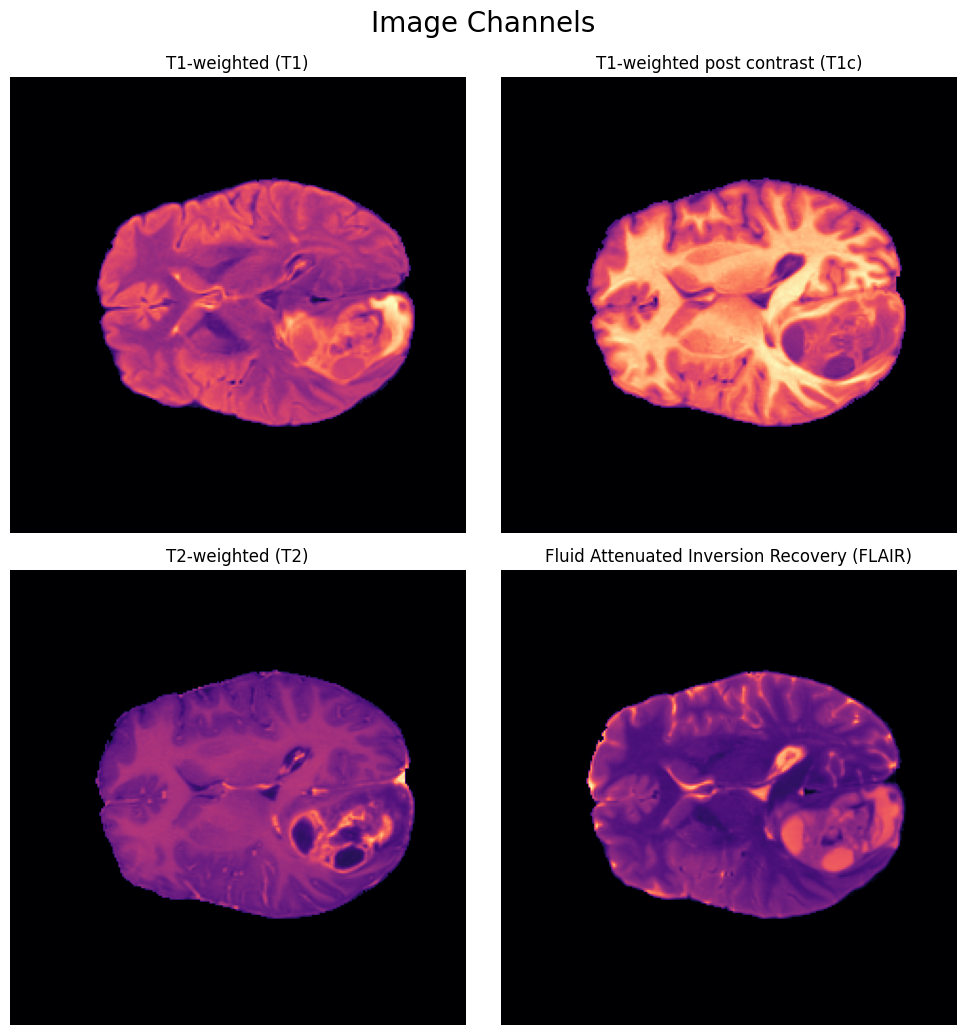

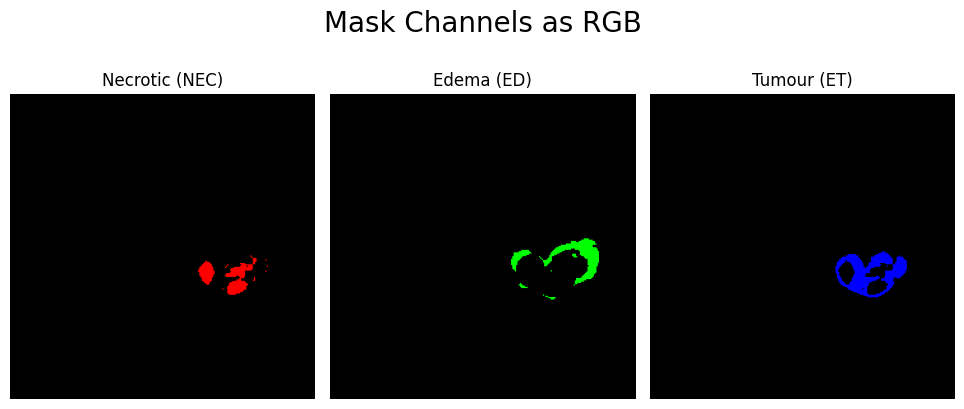

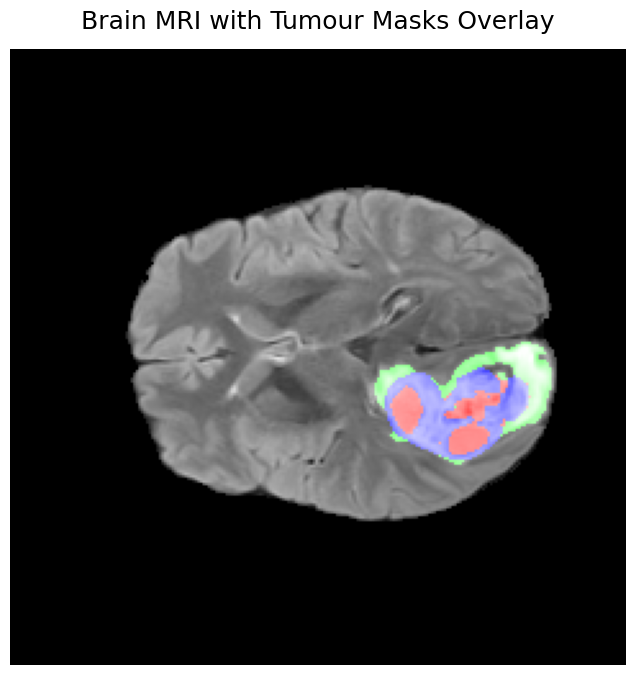

In [3]:
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
# plt.rcParams['figure.facecolor'] = '#171717'
# plt.rcParams['text.color']       = '#DDDDDD'

def display_image_channels(image, title='Image Channels'):
    channel_names = ['T1-weighted (T1)', 'T1-weighted post contrast (T1c)', 'T2-weighted (T2)', 'Fluid Attenuated Inversion Recovery (FLAIR)']
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    for idx, ax in enumerate(axes.flatten()):
        channel_image = image[idx, :, :]  # Transpose the array to display the channel
        ax.imshow(channel_image, cmap='magma')    
        ax.axis('off')
        ax.set_title(channel_names[idx])
    plt.tight_layout()
    plt.suptitle(title, fontsize=20, y=1.03)
    plt.show()

def display_mask_channels_as_rgb(mask, title='Mask Channels as RGB'):
    channel_names = ['Necrotic (NEC)', 'Edema (ED)', 'Tumour (ET)']
    fig, axes = plt.subplots(1, 3, figsize=(9.75, 5))
    for idx, ax in enumerate(axes):
        rgb_mask = np.zeros((mask.shape[1], mask.shape[2], 3), dtype=np.uint8)
        rgb_mask[..., idx] = mask[idx, :, :] * 255  # Transpose the array to display the channel
        ax.imshow(rgb_mask)
        ax.axis('off')
        ax.set_title(channel_names[idx])
    plt.suptitle(title, fontsize=20, y=0.93)
    plt.tight_layout()
    plt.show()

def overlay_masks_on_image(image, mask, title='Brain MRI with Tumour Masks Overlay'):
    t1_image = image[0, :, :]  # Use the first channel of the image
    t1_image_normalized = (t1_image - t1_image.min()) / (t1_image.max() - t1_image.min())

    rgb_image = np.stack([t1_image_normalized] * 3, axis=-1)
    color_mask = np.stack([mask[0, :, :], mask[1, :, :], mask[2, :, :]], axis=-1)
    rgb_image = np.where(color_mask, color_mask, rgb_image)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(rgb_image)
    plt.title(title, fontsize=18, y=1.02)
    plt.axis('off')
    plt.show()
    
    
# Sample image to view
sample_selected = random.choice(h5_files)
sample_file_path = os.path.join(directory, sample_selected)
data = {}
with h5py.File(sample_file_path, 'r') as file:
    for key in file.keys():
        data[key] = file[key][()]

# Transpose the image and mask to have channels first
image = data['image'].transpose(2, 0, 1)
mask = data['mask'].transpose(2, 0, 1)

# View images using plotting functions
display_image_channels(image)
display_mask_channels_as_rgb(mask)
overlay_masks_on_image(image, mask)

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader

class BrainScanDataset(Dataset):
    def __init__(self, file_paths, deterministic=False):
        self.file_paths = file_paths
        if deterministic:  # To always generate the same test images for consistency
            np.random.seed(1)
        np.random.shuffle(self.file_paths)
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        # Load h5 file, get image and mask
        file_path = self.file_paths[idx]
        with h5py.File(file_path, 'r') as file:
            image = file['image'][()]
            mask = file['mask'][()]
            
            # Reshape: (H, W, C) -> (C, H, W)
            image = image.transpose((2, 0, 1))
            mask = mask.transpose((2, 0, 1))
            
            # Adjusting pixel values for each channel in the image so they are between 0 and 255
            for i in range(image.shape[0]):    # Iterate over channels
                min_val = np.min(image[i])     # Find the min value in the channel
                image[i] = image[i] - min_val  # Shift values to ensure min is 0
                max_val = np.max(image[i]) + 1e-4     # Find max value to scale max to 1 now.
                image[i] = image[i] / max_val
            
            # Convert to float and scale the whole image
            image = torch.tensor(image, dtype=torch.float32)
            mask = torch.tensor(mask, dtype=torch.float32) 
            
        return image, mask

# Build .h5 file paths from directory containing .h5 files
h5_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.h5')]
np.random.seed(42)
np.random.shuffle(h5_files)

# Split the dataset into train and validation sets (80:10)
split_idx = int(0.8 * len(h5_files))
train_files = h5_files[:split_idx]
val_files = h5_files[split_idx:]

# Create the train and val datasets
train_dataset = BrainScanDataset(train_files)
val_dataset = BrainScanDataset(val_files, deterministic=True)

# Sample dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=5, shuffle=False)

# Use this to generate test images to view later
test_input_iterator = iter(DataLoader(val_dataset, batch_size=1, shuffle=True))

# Verifying dataloaders work
for images, masks in train_dataloader:
    print("Training batch - Images shape:", images.shape, "Masks shape:", masks.shape)
    break
for images, masks in val_dataloader:
    print("Validation batch - Images shape:", images.shape, "Masks shape:", masks.shape)
    break

Training batch - Images shape: torch.Size([5, 4, 240, 240]) Masks shape: torch.Size([5, 3, 240, 240])
Validation batch - Images shape: torch.Size([5, 4, 240, 240]) Masks shape: torch.Size([5, 3, 240, 240])


In [4]:
from torch import nn

def encoder_block(in_channels, out_channels, activation=nn.ReLU()):
    """
    Creates an encoder block with two convolutional layers followed by activation.
    
    Parameters:
    - in_channels (int): Number of input channels.
    - out_channels (int): Number of output channels.
    - activation (nn.Module): Activation function.
    
    Returns:
    - nn.Sequential: Encoder block.
    """
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        activation,
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        activation
    )

def decoder_block(in_channels, out_channels, activation=nn.ReLU()):
    """
    Creates a decoder block with two convolutional layers followed by activation.
    
    Parameters:
    - in_channels (int): Number of input channels.
    - out_channels (int): Number of output channels.
    - activation (nn.Module): Activation function.
    
    Returns:
    - nn.Sequential: Decoder block.
    """
    return nn.Sequential(
        nn.Conv2d(in_channels, in_channels // 2, kernel_size=3, stride=1, padding=1),
        activation,
        nn.Conv2d(in_channels // 2, out_channels, kernel_size=3, stride=1, padding=1),
        activation
    )

In [5]:
class UNet(nn.Module):
    def __init__(self, in_channels=4, out_channels=3, n_filters=32, activation=nn.ReLU()):
        """
        Initializes the U-Net model.
        
        Parameters:
        - in_channels (int): Number of input channels.
        - out_channels (int): Number of output channels.
        - n_filters (int): Base number of filters.
        - activation (nn.Module): Activation function.
        """
        super(UNet, self).__init__()
        
        # Downsampling method
        self.downsample = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Upsampling method
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        # Encoder
        self.enc1 = encoder_block(in_channels, 1 * n_filters, activation)
        self.enc2 = encoder_block(1 * n_filters, 2 * n_filters, activation)
        self.enc3 = encoder_block(2 * n_filters, 4 * n_filters, activation)
        self.enc4 = encoder_block(4 * n_filters, 8 * n_filters, activation)
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(8 * n_filters, 16 * n_filters, kernel_size=3, stride=1, padding=1),
            activation,
            nn.Conv2d(16 * n_filters, 8 * n_filters, kernel_size=3, stride=1, padding=1),
            activation
        )
        
        # Decoder
        self.dec4 = decoder_block(16 * n_filters, 4 * n_filters, activation)
        self.dec3 = decoder_block(8 * n_filters, 2 * n_filters, activation)
        self.dec2 = decoder_block(4 * n_filters, 1 * n_filters, activation)
        self.dec1 = decoder_block(2 * n_filters, 1 * n_filters, activation)
        
        # Output layer
        self.output = nn.Conv2d(1 * n_filters, out_channels, kernel_size=1, stride=1, padding=0)
        
    def forward(self, x):
        # Encoder pathway
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.downsample(enc1))
        enc3 = self.enc3(self.downsample(enc2))
        enc4 = self.enc4(self.downsample(enc3))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.downsample(enc4))
        
        # Decoder pathway with skip connections
        dec4 = self.dec4(torch.cat([self.upsample(bottleneck), enc4], dim=1))
        dec3 = self.dec3(torch.cat([self.upsample(dec4), enc3], dim=1))
        dec2 = self.dec2(torch.cat([self.upsample(dec3), enc2], dim=1))
        dec1 = self.dec1(torch.cat([self.upsample(dec2), enc1], dim=1))
        
        # Output layer
        out = self.output(dec1)
        return out

In [5]:
def count_parameters(model):
    """
    Counts and prints the number of trainable parameters in the model.
    
    Parameters:
    - model (nn.Module): The neural network model.
    """
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Total Parameters: {total_params:,}\n')

def save_model(model, path='model_weights.pth'):
    """
    Saves the model's state dictionary to the specified path.
    
    Parameters:
    - model (nn.Module): The neural network model.
    - path (str): File path to save the model weights.
    """
    torch.save(model.state_dict(), path)

In [7]:
train_config = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'n_epochs':          20,
    'batch_size':        64,
    'learning_rate':     0.001,
    'batches_per_epoch': 64,
    'lr_decay_factor':   1,
    'optimizer_type': 'Adam'
}

# Instantiate the model
activation_function = nn.LeakyReLU(negative_slope=0.1)  #using leaky relu in place of relu
model = UNet(in_channels=4, out_channels=3, n_filters=32, activation=activation_function)

# Count parameters
count_parameters(model)

# Move model to device
device = torch.device(train_config['device'])
model = model.to(device)

Total Parameters: 5,496,451



In [6]:
def dice_coefficient(preds, targets, smooth=1e-6):
    """
    Computes the Dice coefficient between predictions and targets.
    
    Args:
    - preds (torch.Tensor): The predicted output from the model (logits).
    - targets (torch.Tensor): The ground truth binary masks.
    - smooth (float): Smoothing factor to avoid division by zero.
    
    Returns:
    - dice (float): The Dice coefficient for the batch.
    """
    # Apply sigmoid to the predicted logits
    preds = torch.sigmoid(preds)
    
    # Threshold to get binary predictions (0 or 1)
    preds = (preds > 0.5).float()
    
    # Flatten tensors to 1D for all the pixels in the batch
    preds = preds.view(-1)
    targets = targets.view(-1)
    
    # Compute the intersection and union
    intersection = (preds * targets).sum()
    dice = (2.0 * intersection + smooth) / (preds.sum() + targets.sum() + smooth)
    
    return dice.item()

In [7]:
def calculate_precision(preds, targets, smooth=1e-6):
    """
    Computes precision between predictions and targets.
    """
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()
    preds = preds.view(-1)
    targets = targets.view(-1)

    true_positives = (preds * targets).sum()
    predicted_positives = preds.sum()

    precision_value = (true_positives + smooth) / (predicted_positives + smooth)
    return precision_value.item()

In [8]:
def calculate_recall(preds, targets, smooth=1e-6):
    """
    Computes recall between predictions and targets.
    """
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()
    preds = preds.view(-1)
    targets = targets.view(-1)

    true_positives = (preds * targets).sum()
    actual_positives = targets.sum()

    recall_value = (true_positives + smooth) / (actual_positives + smooth)
    return recall_value.item()

In [9]:
def calculate_accuracy(preds, targets):
    """
    Computes accuracy between predictions and targets.
    """
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()
    preds = preds.view(-1)
    targets = targets.view(-1)

    correct = (preds == targets).float().sum()
    total = targets.numel()

    accuracy_value = correct / total
    return accuracy_value.item()

In [25]:
def train_model(model, train_dataloader, val_dataloader, config, verbose=True):
    device = config['device']
    n_epochs = config['n_epochs']
    learning_rate = config['learning_rate']
    batches_per_epoch = config['batches_per_epoch']
    lr_decay_factor = config['lr_decay_factor']
    optimizer_type = config['optimizer_type']

    # model.to(device)
    # optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # loss_fn = nn.BCEWithLogitsLoss()
    model.to(device)
    loss_fn = nn.BCEWithLogitsLoss()

    if optimizer_type == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_type == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
    elif optimizer_type == 'RMSprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    elif optimizer_type == 'Adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    elif optimizer_type == 'Nadam':
        optimizer = torch.optim.NAdam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    else:
        raise ValueError(f"Unsupported optimizer type: {optimizer_type}")
    
    train_epoch_losses = []
    val_epoch_losses = []
    
    print("Training...")
    for epoch in range(1, n_epochs + 1):
        # Decay learning rate
        current_lr = learning_rate * (lr_decay_factor ** (epoch - 1))
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_lr

        # Training step
        model.train()
        train_epoch_loss = 0
        total_dice, total_precision, total_recall, total_accuracy = 0, 0, 0, 0
        for train_batch_idx, (train_inputs, train_targets) in enumerate(train_dataloader, start=1):
            if verbose: 
                print(f"\rTrain batch: {train_batch_idx}/{batches_per_epoch}, Avg batch loss: {train_epoch_loss/train_batch_idx:.6f}", end='')
            
            train_inputs = train_inputs.to(device)
            train_targets = train_targets.to(device)
            
            # Forward pass
            train_preds = model(train_inputs)
            train_batch_loss = loss_fn(train_preds, train_targets)
            train_epoch_loss += train_batch_loss.item()

            optimizer.zero_grad()
            train_batch_loss.backward()
            optimizer.step()

            # Calculate metrics
            dice_score = dice_coefficient(train_preds, train_targets)
            precision = calculate_precision(train_preds, train_targets)
            recall = calculate_recall(train_preds, train_targets)
            accuracy = calculate_accuracy(train_preds, train_targets)

            total_dice += dice_score
            total_precision += precision
            total_recall += recall
            total_accuracy += accuracy

            if train_batch_idx >= batches_per_epoch:
                if verbose: print()
                break

        # Average metrics for the epoch
        avg_train_loss = train_epoch_loss / batches_per_epoch
        avg_dice = total_dice / batches_per_epoch
        avg_precision = total_precision / batches_per_epoch
        avg_recall = total_recall / batches_per_epoch
        avg_accuracy = total_accuracy / batches_per_epoch

        print(f"\nEpoch {epoch}/{n_epochs}:")
        print(f"Training Loss: {avg_train_loss:.4f}, Dice: {avg_dice:.4f}, Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, Accuracy: {avg_accuracy:.4f}")

        train_epoch_losses.append(avg_train_loss)

        # Validation step
        avg_val_loss, avg_val_dice, avg_val_precision, avg_val_recall, avg_val_accuracy = validate_model(model, val_dataloader, loss_fn, device)
        print(f"Validation Loss: {avg_val_loss:.4f}, Dice: {avg_val_dice:.4f}, Precision: {avg_val_precision:.4f}, Recall: {avg_val_recall:.4f}, Accuracy: {avg_val_accuracy:.4f}")
        val_epoch_losses.append(avg_val_loss)

    return train_epoch_losses, val_epoch_losses


def validate_model(model, val_dataloader, loss_fn, device):
    """
    Validates the model on the validation dataset and calculates performance metrics.

    Parameters:
    - model (torch.nn.Module): The model to validate.
    - val_dataloader (torch.utils.data.DataLoader): Dataloader for validation data.
    - loss_fn (torch.nn.Module): Loss function used for validation.
    - device (str): The device to run the validation on ('cpu' or 'cuda').

    Returns:
    - val_loss (float): Average validation loss for the epoch.
    - dice (float): Average Dice coefficient for the epoch.
    - precision (float): Average precision for the epoch.
    - recall (float): Average recall for the epoch.
    - accuracy (float): Average accuracy for the epoch.
    """
    model.eval()
    val_loss = 0.0
    dice_total = 0.0
    precision_total = 0.0
    recall_total = 0.0
    accuracy_total = 0.0
    n_batches = len(val_dataloader)

    with torch.no_grad():  # Disable gradient calculation for validation
        for val_inputs, val_targets in val_dataloader:
            val_inputs = val_inputs.to(device)
            val_targets = val_targets.to(device)

            # Forward pass
            val_preds = model(val_inputs)

            # Loss calculation
            loss = loss_fn(val_preds, val_targets)
            val_loss += loss.item()

            # Metric calculations
            dice_total += dice_coefficient(val_preds, val_targets)
            precision_total += calculate_precision(val_preds, val_targets)
            recall_total += calculate_recall(val_preds, val_targets)
            accuracy_total += calculate_accuracy(val_preds, val_targets)

    # Calculate average values for the metrics
    val_loss /= n_batches
    dice_total /= n_batches
    precision_total /= n_batches
    recall_total /= n_batches
    accuracy_total /= n_batches

    return val_loss, dice_total, precision_total, recall_total, accuracy_total

# With Adam

In [13]:
# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=train_config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=train_config['batch_size'], shuffle=False)

# Train model
train_epoch_losses, val_epoch_losses = train_model(model, train_dataloader, val_dataloader, train_config, verbose=False)

Training...

Epoch 1/20:
Training Loss: 0.0670, Dice: 0.0005, Precision: 0.9223, Recall: 0.0076, Accuracy: 0.9809
Validation Loss: 0.0171, Dice: 0.0000, Precision: 1.0000, Recall: 0.0000, Accuracy: 0.9963

Epoch 2/20:
Training Loss: 0.0145, Dice: 0.0638, Precision: 0.6560, Recall: 0.0400, Accuracy: 0.9961
Validation Loss: 0.0149, Dice: 0.3523, Precision: 0.3926, Recall: 0.3226, Accuracy: 0.9957

Epoch 3/20:
Training Loss: 0.0109, Dice: 0.2939, Precision: 0.5106, Recall: 0.2141, Accuracy: 0.9962
Validation Loss: 0.0109, Dice: 0.2204, Precision: 0.5432, Recall: 0.1397, Accuracy: 0.9964

Epoch 4/20:
Training Loss: 0.0099, Dice: 0.3047, Precision: 0.5371, Recall: 0.2213, Accuracy: 0.9963
Validation Loss: 0.0090, Dice: 0.3004, Precision: 0.6182, Recall: 0.2002, Accuracy: 0.9966

Epoch 5/20:
Training Loss: 0.0087, Dice: 0.3730, Precision: 0.6085, Recall: 0.2752, Accuracy: 0.9966
Validation Loss: 0.0086, Dice: 0.3566, Precision: 0.6777, Recall: 0.2457, Accuracy: 0.9968

Epoch 6/20:
Training L

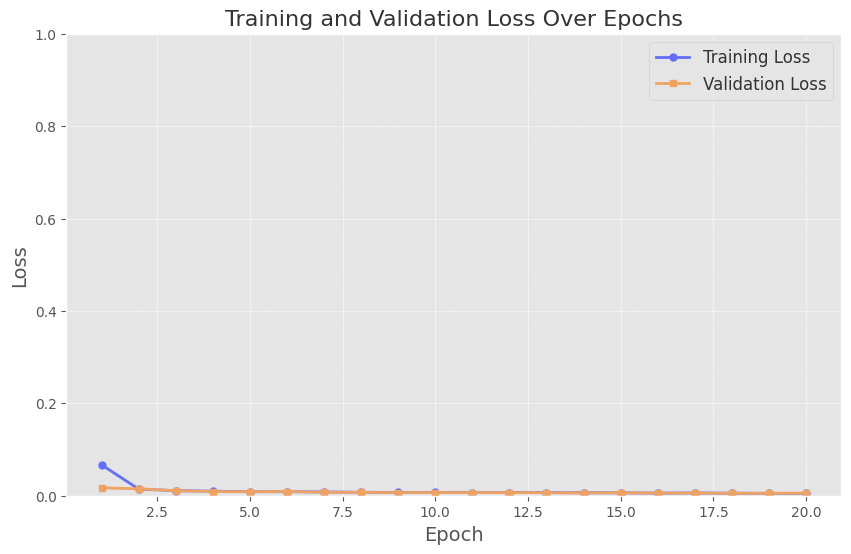

In [14]:
def plot_learning_curves(train_epoch_losses, val_epoch_losses):
    plt.style.use('ggplot')
    plt.rcParams['text.color'] = '#333333'

    fig, axis = plt.subplots(1, 1, figsize=(10, 6))

    # Plot training and validation loss (NaN is used to offset epochs by 1)
    axis.plot([np.NaN] + train_epoch_losses, color='#636EFA', marker='o', linestyle='-', linewidth=2, markersize=5, label='Training Loss')
    axis.plot([np.NaN] + val_epoch_losses,   color='#EFA363', marker='s', linestyle='-', linewidth=2, markersize=5, label='Validation Loss')

    # Adding title, labels and formatting
    axis.set_title('Training and Validation Loss Over Epochs', fontsize=16)
    axis.set_xlabel('Epoch', fontsize=14)
    axis.set_ylabel('Loss', fontsize=14)

    axis.set_ylim(0, 1)
    
    axis.legend(fontsize=12)
    axis.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()
    
plot_learning_curves(train_epoch_losses, val_epoch_losses)

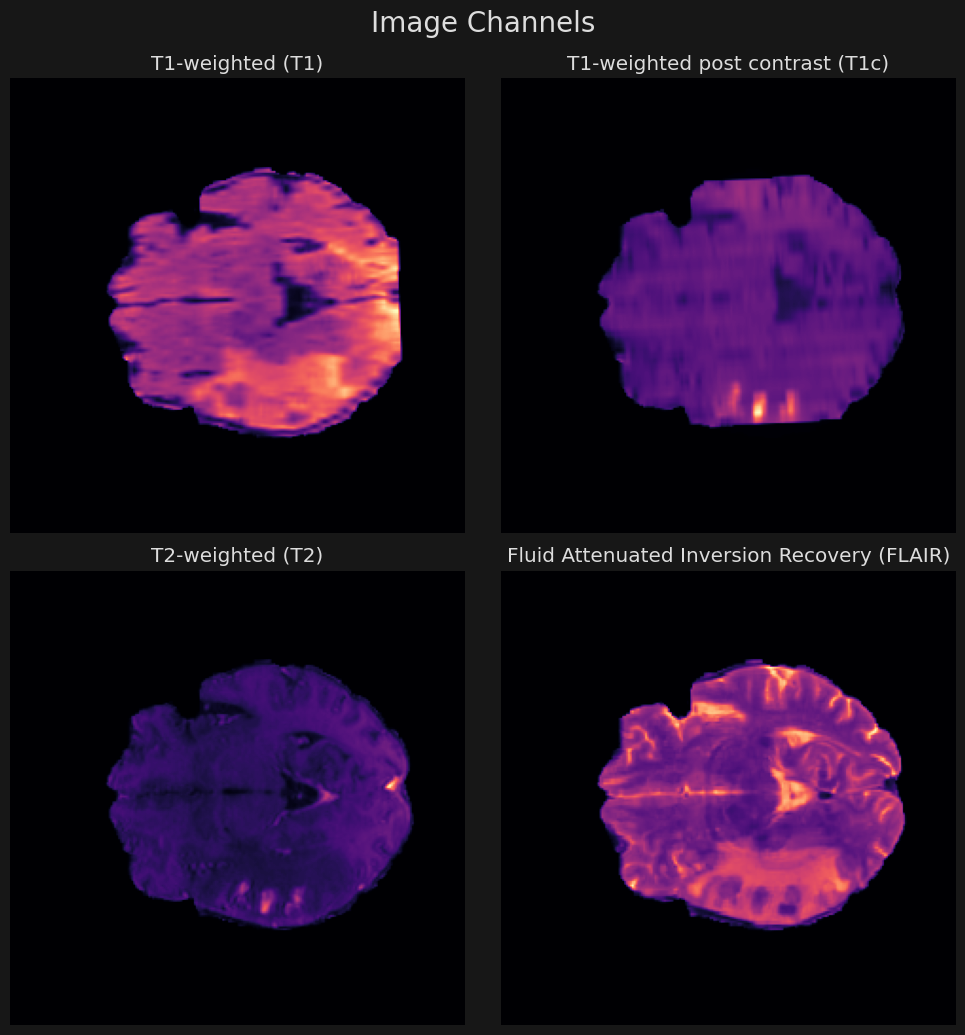

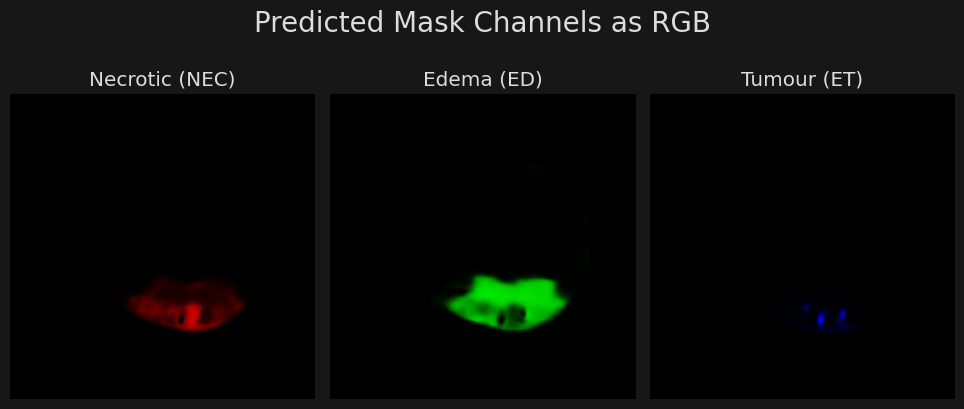

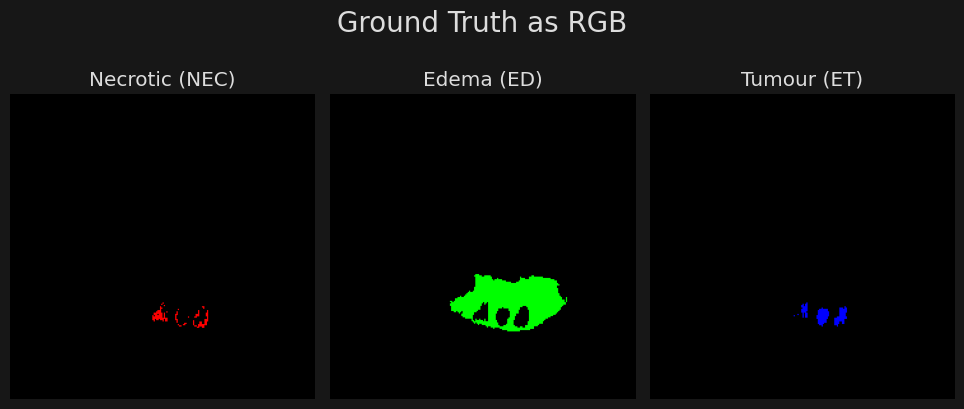

In [20]:
def display_test_sample(model, test_input, test_target, device):
    test_input, test_target = test_input.to(device), test_target.to(device)

    # Obtain the model's prediction
    test_pred = torch.sigmoid(model(test_input))

    # Process the image and masks for visualization
    image = test_input.detach().cpu().numpy().squeeze(0)
    mask_pred = test_pred.detach().cpu().numpy().squeeze(0)
    mask_target = test_target.detach().cpu().numpy().squeeze(0)

    # Set the plot aesthetics
    plt.rcParams['figure.facecolor'] = '#171717'
    plt.rcParams['text.color']       = '#DDDDDD'

    # Display the input image, predicted mask, and target mask
    display_image_channels(image)
    display_mask_channels_as_rgb(mask_pred, title='Predicted Mask Channels as RGB')
    display_mask_channels_as_rgb(mask_target, title='Ground Truth as RGB')
    

# Set so model and these images are on the same device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
# Get an image from the validation dataset that the model hasn't been trained on
test_input, test_target = next(test_input_iterator)

display_test_sample(model, test_input, test_target, device)

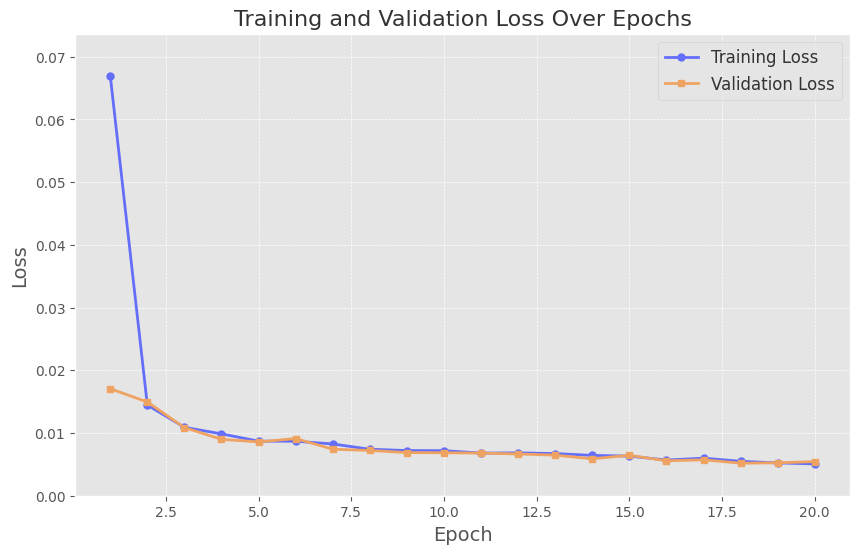

In [22]:
import matplotlib.pyplot as plt
import numpy as np

def plot_learning_curves(train_epoch_losses, val_epoch_losses):
    """
    Plots the training and validation loss curves over epochs.

    Parameters:
    - train_epoch_losses (list): List of training loss values for each epoch.
    - val_epoch_losses (list): List of validation loss values for each epoch.
    """
    # Set plot style
    plt.style.use('ggplot')
    plt.rcParams['text.color'] = '#333333'

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot training and validation losses
    ax.plot(
        [np.NaN] + train_epoch_losses, 
        color='#636EFA', 
        marker='o', 
        linestyle='-', 
        linewidth=2, 
        markersize=5, 
        label='Training Loss'
    )
    ax.plot(
        [np.NaN] + val_epoch_losses, 
        color='#EFA363', 
        marker='s', 
        linestyle='-', 
        linewidth=2, 
        markersize=5, 
        label='Validation Loss'
    )

    # Add title, labels, legend, and grid
    ax.set_title('Training and Validation Loss Over Epochs', fontsize=16)
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_ylabel('Loss', fontsize=14)
    ax.set_ylim(0, max(max(train_epoch_losses), max(val_epoch_losses)) * 1.1)  # Dynamic y-axis
    ax.legend(fontsize=12)
    ax.grid(True, linestyle='--', linewidth=0.5)

    # Show the plot
    plt.show()


plot_learning_curves(train_epoch_losses, val_epoch_losses)


# With SGD

In [23]:
train_config = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'n_epochs':          20,
    'batch_size':        64,
    'learning_rate':     0.001,
    'batches_per_epoch': 64,
    'lr_decay_factor':   1,
    'optimizer_type': 'SGD'
}

# Instantiate the model
activation_function = nn.LeakyReLU(negative_slope=0.1)  #using leaky relu in place of relu
model = UNet(in_channels=4, out_channels=3, n_filters=32, activation=activation_function)

# Count parameters
count_parameters(model)

# Move model to device
device = torch.device(train_config['device'])
model = model.to(device)

Total Parameters: 5,496,451



In [24]:
# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=train_config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=train_config['batch_size'], shuffle=False)

# Train model
train_epoch_losses, val_epoch_losses = train_model(model, train_dataloader, val_dataloader, train_config, verbose=False)

Training...

Epoch 1/20:
Training Loss: 0.0848, Dice: 0.0021, Precision: 0.8493, Recall: 0.0133, Accuracy: 0.9707
Validation Loss: 0.0187, Dice: 0.0000, Precision: 1.0000, Recall: 0.0000, Accuracy: 0.9963

Epoch 2/20:
Training Loss: 0.0136, Dice: 0.0724, Precision: 0.4832, Recall: 0.0452, Accuracy: 0.9963
Validation Loss: 0.0125, Dice: 0.1590, Precision: 0.5095, Recall: 0.0953, Accuracy: 0.9963

Epoch 3/20:
Training Loss: 0.0105, Dice: 0.2112, Precision: 0.5348, Recall: 0.1395, Accuracy: 0.9965
Validation Loss: 0.0111, Dice: 0.0537, Precision: 0.6580, Recall: 0.0281, Accuracy: 0.9964

Epoch 4/20:
Training Loss: 0.0099, Dice: 0.2971, Precision: 0.5371, Recall: 0.2119, Accuracy: 0.9964
Validation Loss: 0.0093, Dice: 0.3682, Precision: 0.5249, Recall: 0.2853, Accuracy: 0.9964

Epoch 5/20:
Training Loss: 0.0094, Dice: 0.3309, Precision: 0.5592, Recall: 0.2482, Accuracy: 0.9963
Validation Loss: 0.0087, Dice: 0.3462, Precision: 0.6160, Recall: 0.2424, Accuracy: 0.9967

Epoch 6/20:
Training L

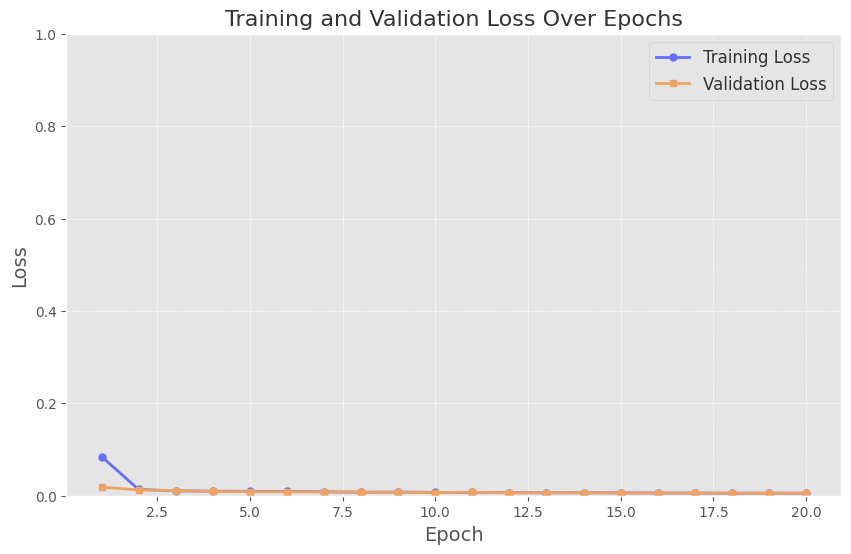

In [25]:
def plot_learning_curves(train_epoch_losses, val_epoch_losses):
    plt.style.use('ggplot')
    plt.rcParams['text.color'] = '#333333'

    fig, axis = plt.subplots(1, 1, figsize=(10, 6))

    # Plot training and validation loss (NaN is used to offset epochs by 1)
    axis.plot([np.NaN] + train_epoch_losses, color='#636EFA', marker='o', linestyle='-', linewidth=2, markersize=5, label='Training Loss')
    axis.plot([np.NaN] + val_epoch_losses,   color='#EFA363', marker='s', linestyle='-', linewidth=2, markersize=5, label='Validation Loss')

    # Adding title, labels and formatting
    axis.set_title('Training and Validation Loss Over Epochs', fontsize=16)
    axis.set_xlabel('Epoch', fontsize=14)
    axis.set_ylabel('Loss', fontsize=14)

    axis.set_ylim(0, 1)
    
    axis.legend(fontsize=12)
    axis.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()
    
plot_learning_curves(train_epoch_losses, val_epoch_losses)

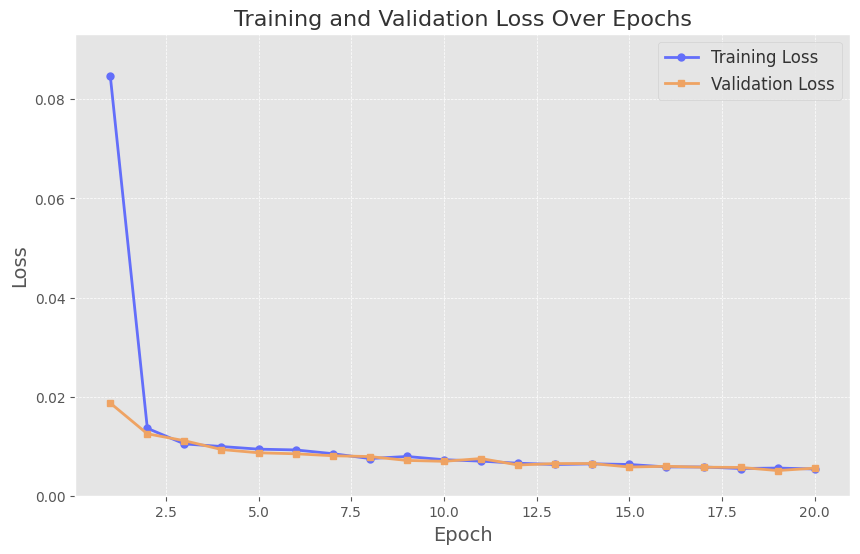

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def plot_learning_curves(train_epoch_losses, val_epoch_losses):
    """
    Plots the training and validation loss curves over epochs.

    Parameters:
    - train_epoch_losses (list): List of training loss values for each epoch.
    - val_epoch_losses (list): List of validation loss values for each epoch.
    """
    # Set plot style
    plt.style.use('ggplot')
    plt.rcParams['text.color'] = '#333333'

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot training and validation losses
    ax.plot(
        [np.NaN] + train_epoch_losses, 
        color='#636EFA', 
        marker='o', 
        linestyle='-', 
        linewidth=2, 
        markersize=5, 
        label='Training Loss'
    )
    ax.plot(
        [np.NaN] + val_epoch_losses, 
        color='#EFA363', 
        marker='s', 
        linestyle='-', 
        linewidth=2, 
        markersize=5, 
        label='Validation Loss'
    )

    # Add title, labels, legend, and grid
    ax.set_title('Training and Validation Loss Over Epochs', fontsize=16)
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_ylabel('Loss', fontsize=14)
    ax.set_ylim(0, max(max(train_epoch_losses), max(val_epoch_losses)) * 1.1)  # Dynamic y-axis
    ax.legend(fontsize=12)
    ax.grid(True, linestyle='--', linewidth=0.5)

    # Show the plot
    plt.show()


plot_learning_curves(train_epoch_losses, val_epoch_losses)


# Unet with Dropout

In [14]:
from torch import nn 
def encoder_block_drop(in_channels, out_channels, activation=nn.ReLU(), drop_out_rate=0.5):
    """
    Creates an encoder block with two convolutional layers followed by activation.
    
    Parameters:
    - in_channels (int): Number of input channels.
    - out_channels (int): Number of output channels.
    - activation (nn.Module): Activation function.
    
    Returns:
    - nn.Sequential: Encoder block.
    """
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        activation,
        nn.Dropout(p=drop_out_rate),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        activation
    )

def decoder_block_drop(in_channels, out_channels, activation=nn.ReLU(), drop_out_rate=0.5):
    """
    Creates a decoder block with two convolutional layers followed by activation.
    
    Parameters:
    - in_channels (int): Number of input channels.
    - out_channels (int): Number of output channels.
    - activation (nn.Module): Activation function.
    
    Returns:
    - nn.Sequential: Decoder block.
    """
    return nn.Sequential(
        nn.Conv2d(in_channels, in_channels // 2, kernel_size=3, stride=1, padding=1),
        activation,
        nn.Dropout(p=drop_out_rate),
        nn.Conv2d(in_channels // 2, out_channels, kernel_size=3, stride=1, padding=1),
        activation
    )

In [22]:
class UNet_Drop(nn.Module):
    def __init__(self, in_channels=4, out_channels=3, n_filters=32, activation=nn.ReLU(), drop_out_rate=0.5):
        """
        Initializes the U-Net model.
        
        Parameters:
        - in_channels (int): Number of input channels.
        - out_channels (int): Number of output channels.
        - n_filters (int): Base number of filters.
        - activation (nn.Module): Activation function.
        """
        super(UNet_Drop, self).__init__()
        
        # Downsampling method
        self.downsample = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Upsampling method
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        # Encoder
        self.enc1 = encoder_block_drop(in_channels, 1 * n_filters, activation, drop_out_rate)
        self.enc2 = encoder_block_drop(1 * n_filters, 2 * n_filters, activation, drop_out_rate)
        self.enc3 = encoder_block_drop(2 * n_filters, 4 * n_filters, activation, drop_out_rate)
        self.enc4 = encoder_block_drop(4 * n_filters, 8 * n_filters, activation, drop_out_rate)
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(8 * n_filters, 16 * n_filters, kernel_size=3, stride=1, padding=1),
            activation,
            nn.Dropout(p=drop_out_rate),
            nn.Conv2d(16 * n_filters, 8 * n_filters, kernel_size=3, stride=1, padding=1),
            activation
        )
        
        # Decoder
        self.dec4 = decoder_block_drop(16 * n_filters, 4 * n_filters, activation, drop_out_rate)
        self.dec3 = decoder_block_drop(8 * n_filters, 2 * n_filters, activation, drop_out_rate)
        self.dec2 = decoder_block_drop(4 * n_filters, 1 * n_filters, activation, drop_out_rate)
        self.dec1 = decoder_block_drop(2 * n_filters, 1 * n_filters, activation, drop_out_rate)
        
        # Output layer
        self.output = nn.Conv2d(1 * n_filters, out_channels, kernel_size=1, stride=1, padding=0)
        
    def forward(self, x):
        # Encoder pathway
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.downsample(enc1))
        enc3 = self.enc3(self.downsample(enc2))
        enc4 = self.enc4(self.downsample(enc3))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.downsample(enc4))
        
        # Decoder pathway with skip connections
        dec4 = self.dec4(torch.cat([self.upsample(bottleneck), enc4], dim=1))
        dec3 = self.dec3(torch.cat([self.upsample(dec4), enc3], dim=1))
        dec2 = self.dec2(torch.cat([self.upsample(dec3), enc2], dim=1))
        dec1 = self.dec1(torch.cat([self.upsample(dec2), enc1], dim=1))
        
        # Output layer
        out = self.output(dec1)
        return out

In [27]:
drop_train_config = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'n_epochs':          20,
    'batch_size':        32,
    'learning_rate':     0.001,
    'batches_per_epoch': 32,
    'lr_decay_factor':   1,
    'optimizer_type': 'Nadam'
}

# Instantiate the model
activation_function = nn.LeakyReLU(negative_slope=0.1)  #using leaky relu in place of relu
model_drop = UNet_Drop(in_channels=4, out_channels=3, n_filters=32, activation=activation_function, drop_out_rate=0.3)

# Count parameters
count_parameters(model_drop)

# Move model to device
device = torch.device(drop_train_config['device'])
model_drop = model_drop.to(device)

Total Parameters: 5,496,451



In [28]:
# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=drop_train_config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=drop_train_config['batch_size'], shuffle=False)

# Train model
train_epoch_losses, val_epoch_losses = train_model(model_drop, train_dataloader, val_dataloader, drop_train_config, verbose=False)

Training...

Epoch 1/20:
Training Loss: 0.2183, Dice: 0.0007, Precision: 0.0004, Recall: 0.0321, Accuracy: 0.9413
Validation Loss: 0.0258, Dice: 0.0000, Precision: 1.0000, Recall: 0.0000, Accuracy: 0.9963

Epoch 2/20:
Training Loss: 0.0227, Dice: 0.0002, Precision: 0.0365, Recall: 0.0001, Accuracy: 0.9964
Validation Loss: 0.0209, Dice: 0.0000, Precision: 1.0000, Recall: 0.0000, Accuracy: 0.9963

Epoch 3/20:
Training Loss: 0.0224, Dice: 0.0000, Precision: 0.5031, Recall: 0.0000, Accuracy: 0.9962
Validation Loss: 0.0310, Dice: 0.0000, Precision: 1.0000, Recall: 0.0000, Accuracy: 0.9963

Epoch 4/20:
Training Loss: 0.0222, Dice: 0.0000, Precision: 0.8125, Recall: 0.0000, Accuracy: 0.9962
Validation Loss: 0.0202, Dice: 0.0008, Precision: 0.5958, Recall: 0.0004, Accuracy: 0.9963

Epoch 5/20:
Training Loss: 0.0190, Dice: 0.0084, Precision: 0.7537, Recall: 0.0055, Accuracy: 0.9964
Validation Loss: 0.0173, Dice: 0.0003, Precision: 0.5068, Recall: 0.0002, Accuracy: 0.9963

Epoch 6/20:
Training L

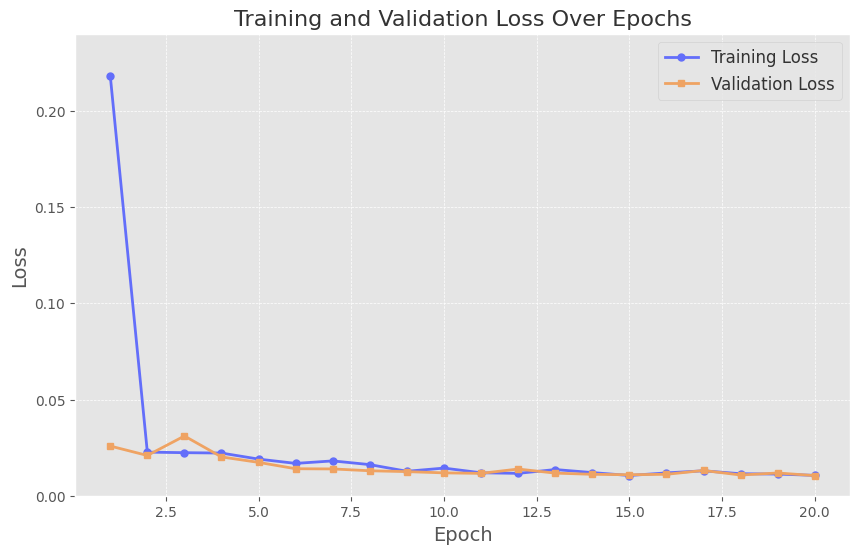

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def plot_learning_curves(train_epoch_losses, val_epoch_losses):
    """
    Plots the training and validation loss curves over epochs.

    Parameters:
    - train_epoch_losses (list): List of training loss values for each epoch.
    - val_epoch_losses (list): List of validation loss values for each epoch.
    """
    # Set plot style
    plt.style.use('ggplot')
    plt.rcParams['text.color'] = '#333333'

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot training and validation losses
    ax.plot(
        [np.NaN] + train_epoch_losses, 
        color='#636EFA', 
        marker='o', 
        linestyle='-', 
        linewidth=2, 
        markersize=5, 
        label='Training Loss'
    )
    ax.plot(
        [np.NaN] + val_epoch_losses, 
        color='#EFA363', 
        marker='s', 
        linestyle='-', 
        linewidth=2, 
        markersize=5, 
        label='Validation Loss'
    )

    # Add title, labels, legend, and grid
    ax.set_title('Training and Validation Loss Over Epochs', fontsize=16)
    ax.set_xlabel('Epoch', fontsize=14)
    ax.set_ylabel('Loss', fontsize=14)
    ax.set_ylim(0, max(max(train_epoch_losses), max(val_epoch_losses)) * 1.1)  # Dynamic y-axis
    ax.legend(fontsize=12)
    ax.grid(True, linestyle='--', linewidth=0.5)

    # Show the plot
    plt.show()


plot_learning_curves(train_epoch_losses, val_epoch_losses)


In [30]:
print(model_drop)

UNet_Drop(
  (downsample): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upsample): Upsample(scale_factor=2.0, mode='bilinear')
  (enc1): Sequential(
    (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
    (2): Dropout(p=0.3, inplace=False)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.1)
  )
  (enc2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
    (2): Dropout(p=0.3, inplace=False)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.1)
  )
  (enc3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
    (2): Dropout(p=0.3, inplace=False)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  

# With Dense and Batch Normalization

In [42]:
def encoder_block_batch(in_channels, out_channels, activation=nn.ReLU()):
    """
    Creates an encoder block with two convolutional layers followed by activation.
    
    Parameters:
    - in_channels (int): Number of input channels.
    - out_channels (int): Number of output channels.
    - activation (nn.Module): Activation function.
    
    Returns:
    - nn.Sequential: Encoder block.
    """
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        activation,
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        activation
    )

def decoder_block_batch(in_channels, out_channels, activation=nn.ReLU()):
    """
    Creates a decoder block with two convolutional layers followed by activation.
    
    Parameters:
    - in_channels (int): Number of input channels.
    - out_channels (int): Number of output channels.
    - activation (nn.Module): Activation function.
    
    Returns:
    - nn.Sequential: Decoder block.
    """
    return nn.Sequential(
        nn.Conv2d(in_channels, in_channels // 2, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(in_channels // 2), 
        activation,
        nn.Conv2d(in_channels // 2, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        activation
    )

In [45]:
class UNet_Batch(nn.Module):
    def __init__(self, in_channels=4, out_channels=3, n_filters=32, activation=nn.ReLU()):
        """
        Initializes the U-Net model.
        
        Parameters:
        - in_channels (int): Number of input channels.
        - out_channels (int): Number of output channels.
        - n_filters (int): Base number of filters.
        - activation (nn.Module): Activation function.
        """
        super(UNet_Batch, self).__init__()
        
        # Downsampling method
        self.downsample = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Upsampling method
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        # Encoder
        self.enc1 = encoder_block_drop(in_channels, 1 * n_filters, activation)
        self.enc2 = encoder_block_drop(1 * n_filters, 2 * n_filters, activation)
        self.enc3 = encoder_block_drop(2 * n_filters, 4 * n_filters, activation)
        self.enc4 = encoder_block_drop(4 * n_filters, 8 * n_filters, activation)
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(8 * n_filters, 16 * n_filters, kernel_size=3, stride=1, padding=1),
            activation,
            nn.Conv2d(16 * n_filters, 8 * n_filters, kernel_size=3, stride=1, padding=1),
            activation
        )
        
        # Decoder
        self.dec4 = decoder_block_drop(16 * n_filters, 4 * n_filters, activation)
        self.dec3 = decoder_block_drop(8 * n_filters, 2 * n_filters, activation)
        self.dec2 = decoder_block_drop(4 * n_filters, 1 * n_filters, activation)
        self.dec1 = decoder_block_drop(2 * n_filters, 1 * n_filters, activation)
        
        # Output layer
        self.output = nn.Conv2d(1 * n_filters, out_channels, kernel_size=1, stride=1, padding=0)
        
    def forward(self, x):
        # Encoder pathway
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.downsample(enc1))
        enc3 = self.enc3(self.downsample(enc2))
        enc4 = self.enc4(self.downsample(enc3))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.downsample(enc4))
        
        # Decoder pathway with skip connections
        dec4 = self.dec4(torch.cat([self.upsample(bottleneck), enc4], dim=1))
        dec3 = self.dec3(torch.cat([self.upsample(dec4), enc3], dim=1))
        dec2 = self.dec2(torch.cat([self.upsample(dec3), enc2], dim=1))
        dec1 = self.dec1(torch.cat([self.upsample(dec2), enc1], dim=1))
        
        # Output layer
        out = self.output(dec1)
        return out

In [49]:
batch_train_config = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'n_epochs':          20,
    'batch_size':        64,
    'learning_rate':     0.001,
    'batches_per_epoch': 64,
    'lr_decay_factor':   1,
    'optimizer_type': 'Nadam'
}

# Instantiate the model
activation_function = nn.LeakyReLU(negative_slope=0.1)  #using leaky relu in place of relu
model_batch = UNet_Batch(in_channels=4, out_channels=3, n_filters=32, activation=activation_function)

# Count parameters
count_parameters(model_batch)

# Move model to device
device = torch.device(batch_train_config['device'])
model_batch = model_batch.to(device)

Total Parameters: 5,496,451



In [50]:
print(model_drop_dense)

UNet_Drop_Dense(
  (downsample): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upsample): Upsample(scale_factor=2.0, mode='bilinear')
  (enc1): Sequential(
    (0): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.1)
  )
  (enc2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, 

In [51]:
# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=dense_drop_train_config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=dense_drop_train_config['batch_size'], shuffle=False)

# Train model
train_epoch_losses, val_epoch_losses = train_model(model_drop_dense, train_dataloader, val_dataloader, dense_drop_train_config, verbose=False)

Training...


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x57600 and 65536x512)